In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from scipy.fftpack import fft
import shutil
from pydub import AudioSegment

from functools import partial
#import ftransc

c:\Users\acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        waveform, sample_rate = load_audio(file_path)
        audio_segment = AudioSegment.from_file(file_path)
        dataset.append([waveform, sample_rate,audio_segment])
    return dataset



In [3]:
burping_data = load_audio_files('./data/sound_data/dustan_baby/burpme_Eh/', 'burpme')
tired_data = load_audio_files('./data/sound_data/dustan_baby/tired_owh/', 'tired')
hungry_data = load_audio_files('./data/sound_data/dustan_baby/hungry_Nah/', 'hungry')
poop_data = load_audio_files('./data/sound_data/dustan_baby/poop_eairh/', 'poop')
discomfort_data = load_audio_files('./data/sound_data/dustan_baby/uncomfortable_heh/', 'discomfort')

In [165]:
feature = []
label = []

In [166]:
def mel_freq(waveform,sample):
    mfccs = librosa.feature.mfcc(waveform, sr=sample,dct_type = 2)
    data=np.mean(librosa.feature.mfcc(waveform,sr=sample,n_mfcc=100).T,axis=0)
    #data = librosa.power_to_db(mfccs)
    # Displaying  the MFCCs:
    #librosa.display.specshow(mfccs, sr=sample, x_axis='hz',cmap = 'magma')
    return data,mfccs

In [167]:
def create_feature(dataset,labeltype):
    # make directory
    for i, data in enumerate(dataset):
        sample_rate = data[1]
        waveform = data[0]
        mean_mfcc,spectrogram = mel_freq(waveform,sample_rate)
        feature.append(mean_mfcc)
        label.append(labeltype)

In [168]:
create_feature(hungry_data,labeltype = 0)
create_feature(tired_data,labeltype = 1)
create_feature(burping_data,labeltype = 2)
create_feature(discomfort_data,labeltype = 3)
create_feature(poop_data,labeltype = 4)

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00752398 -0.00712848 -0.00551579 ...  0.00132812 -0.0019003
 -0.00157612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass y=[-0.00752398 -0.00712848 -0.00551579 ...  0.00132812 -0.0019003
 -0.00157612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-4.6169318e-04 -2.2500433e-04 -7.0232723e-05 ... -1.0660988e-02
 -1.0875039e-02 -5.7732821e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass y=[-4.6169318e

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
import seaborn as sb

In [170]:
feature = np.array(feature)
label = np.array(label)

In [171]:
def dummy(data):
    new_data =[]
    for i in data:
        lab_data =[0,0,0,0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [172]:
label.shape

(166,)

In [173]:
x_train,x_test,y_train,y_test = train_test_split(feature,label,test_size = 0.3,random_state = 48)

In [174]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [175]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(input_shape=(100,), units=100 ,activation='relu'))
model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='softmax'))

In [176]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [177]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [178]:
num_classes= 5

In [179]:
class_count = np.array([np.count_nonzero(y_train ==0),np.count_nonzero(y_train ==1),np.count_nonzero(y_train ==2),np.count_nonzero(y_train ==3),np.count_nonzero(y_train ==4)])

In [180]:
y_train = dummy(y_train)
y_test = dummy(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [181]:
class_count

array([28, 36, 19, 20, 13])

In [182]:
class_weights = {0:0, 1:0,2:0,3:0,4:0}
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [183]:
class_weights

{0: 2.164285714285714,
 1: 1.6833333333333333,
 2: 3.1894736842105265,
 3: 3.03,
 4: 4.661538461538462}

In [184]:
hist=model.fit(x_train,y_train,epochs=100,validation_split=0.3,class_weight = class_weights)

Epoch 1/100
3/3 [==============================] - 0s 56ms/step - loss: 33.9269 - accuracy: 0.1235 - val_loss: 13.6729 - val_accuracy: 0.2000
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 29.6491 - accuracy: 0.2963 - val_loss: 14.3090 - val_accuracy: 0.1714
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 20.9802 - accuracy: 0.2099 - val_loss: 10.8730 - val_accuracy: 0.2286
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 16.1151 - accuracy: 0.2840 - val_loss: 3.2670 - val_accuracy: 0.3143
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 6.3891 - accuracy: 0.3457 - val_loss: 2.2534 - val_accuracy: 0.5714
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 9.2350 - accuracy: 0.3704 - val_loss: 2.1463 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 6.7078 - accuracy: 0.4444 - val_loss: 2.2189 - val_accuracy: 0.2286
Epoch 8/100
3

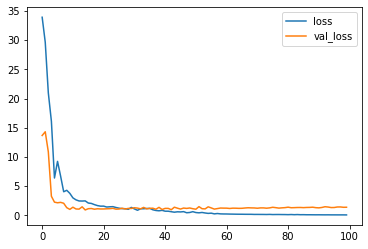

In [185]:
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [186]:
pred = model.predict(x_test)

y_pred = np.argmax(pred, axis=1)
actual = x_test



In [187]:
y_test = np.argmax(y_test, axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

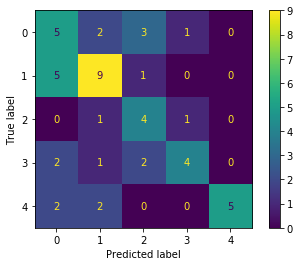

In [188]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show